In [11]:
!pip install einops
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from utils import find_closest_train_segment
from hdst import HDST
import torch
import gc
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Args Configuration Class

In [22]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 16
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0
    mask_mode: str ='all_false'

    sample_size: int = 50
    window_size: int = 20

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [23]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0,
        'global_vatiant_contrast': 0,
        'dynamic_trend_pred': 1,
    },
    eval=False,
    batch_size=32,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

## Load your data
You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.
Choosing from 'ETTh1', 'ETTh2', 'ETTm1' and 'ETTm2'

In [24]:
data, train_slice, valid_slice, test_slice, scaler, pred_lens = datautils.load_forecast_csv("ETTh1")
train_data = data[:, train_slice]
test_data = data[:, test_slice]
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(pred_lens)

Shapes - train data: (1, 8640, 7), test data: (1, 2880, 7)
[24, 48, 168, 336, 720]


## Create and Train the model

In [25]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

9433

In [26]:
import time
start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length,
    mask_mode=args.mask_mode
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (10, 864, 7)
Epoch #0: loss=0.011198261752724648
Epoch #1: loss=0.004625656642019749
Epoch #2: loss=0.0027610871475189924
Epoch #3: loss=0.0018345563439652324
Epoch #4: loss=0.001288287341594696
Epoch #5: loss=0.001022345619276166
Epoch #6: loss=0.000837563187815249
Epoch #7: loss=0.0008042110130190849
Epoch #8: loss=0.0007980057271197438
Epoch #9: loss=0.0007848759414628148
Epoch #10: loss=0.0007514927419833839
Epoch #11: loss=0.0006874779355712235
Epoch #12: loss=0.0006276863277889788
Epoch #13: loss=0.0005821107770316303
Epoch #14: loss=0.0005415573250502348
Epoch #15: loss=0.0005138025153428316
Epoch #16: loss=0.0005028554587624967
Epoch #17: loss=0.0004990812158212066
Epoch #18: loss=0.0004928414127789438
Epoch #19: loss=0.0004792482650373131
Epoch #20: loss=0.0004719353455584496
Epoch #21: loss=0.00046117586316540837
Epoch #22: loss=0.00045313723967410624
Epoch #23: loss=0.0004457082541193813
Epoch #24: loss=0.0004327533533796668
Epoch #25: loss=0.00042436664

Save model and loss log

In [27]:
import torch
torch.save(model, 'logs/mymodel_ETTh1.pth')
import pandas as pd
df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
df.to_csv("logs/loss_log_ETTh1.csv", index=False)

PicklingError: Can't pickle <class 'hdst.HDST'>: it's not the same object as hdst.HDST

Visualize the loss curve and save figure

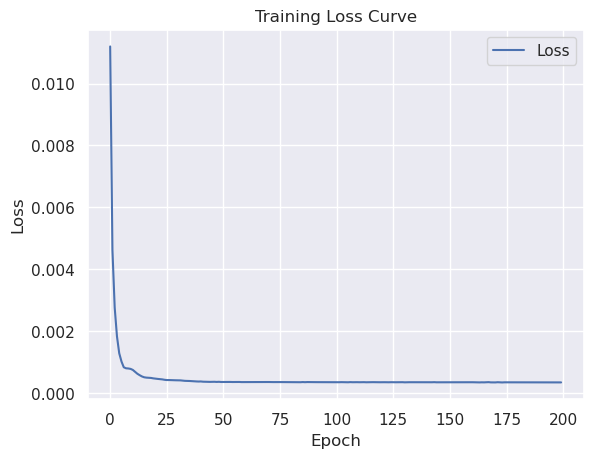

In [28]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a Ridge regression model using training representation and corresponding training labels. Finally, use the Ridge regression model to do forecasting for test representation. Report the MSE and MAE.

In [29]:
from tasks.forecasting import eval_forecasting
out, eval_res = eval_forecasting(
                model,
                data,
                train_slice,
                valid_slice,
                test_slice,
                scaler,
                pred_lens
            )
res=eval_res['ours']
for key, value in res.items():
    print(f"{key}: {value}")


24: {'norm': {'MSE': 0.5231184134611061, 'MAE': 0.49079494901459547}, 'raw': {'MSE': 8.246760067587005, 'MAE': 1.6155858548197928}}
48: {'norm': {'MSE': 0.5603623969611136, 'MAE': 0.5202082426261749}, 'raw': {'MSE': 9.893261013667738, 'MAE': 1.80328987337817}}
168: {'norm': {'MSE': 0.757430635354448, 'MAE': 0.6378980264488245}, 'raw': {'MSE': 13.282496108078261, 'MAE': 2.220729187407128}}
336: {'norm': {'MSE': 0.9311111794879946, 'MAE': 0.7293767640699231}, 'raw': {'MSE': 14.920326875795029, 'MAE': 2.4415203956524323}}
720: {'norm': {'MSE': 1.0836300829540666, 'MAE': 0.8148742887678488}, 'raw': {'MSE': 15.751679646782142, 'MAE': 2.6768136227446937}}
